# COMPENSATION USING TRANSFER FUNCTIONS

We have two general ways to change the characteristics of a system. One is to add external elements such as a controller.
A second approach is to change the system itself. This is called **compensation**.

In [1]:
#!pip -q install tellurium
#!pip -q install control

In [2]:
import numpy as np
import pandas as pd
import tellurium as te
import control
import matplotlib.pyplot as plt
import sympy

In [3]:
TIMES = np.linspace(0, 10, 100)

In [4]:
s = control.TransferFunction.s

# Helpers

In [5]:
TEST_MODEL = """
$S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 = 2
"""
TEST_RR = te.loada(TEST_MODEL)

In [6]:

k1 = TEST_RR["k1"]
k2 = TEST_RR["k2"]
scale = TEST_RR["S1"]
tf = scale*k1*k2/(s*(s+k2))

In [7]:
def evaluateTransferFunction(model, transfer_function, output_name, times=TIMES,
                             is_plot=True):
    """
    Plots simulations versus predictions.

    Args:
        model: (str) antimony
        tranfer_function (control.TransferFunction)
        output_name: (str) prediction
        times: (np.darray)
    Returns:
        float
    """
    rr = te.loada(model)
    data = rr.simulate(times[0], times[-1], len(times))
    output_name = "[" + output_name + "]"
    simulations = data[output_name]
    _, predictions = control.forced_response(transfer_function, T=times, U=1)
    rmse = np.sqrt(np.sum(simulations-predictions)**2)/len(simulations)
    if is_plot:
        plt.scatter(simulations, predictions)
        maxval = max(np.max(predictions), np.max(simulations))
        plt.plot([0, maxval], [0, maxval], color="red")
        plt.xlabel("simulated")
        plt.ylabel("predicted")
    return rmse

rmse = evaluateTransferFunction(TEST_MODEL, tf, "S3", is_plot=False)
assert(rmse < 1e-5)
print("OK!")

OK!


In [8]:
def plotModel(model, times=TIMES, is_plot=True, title="", **kwargs):
    """
    Plots a model.
    
    Args:
       times: np.array 
       kwargs: values of parameters
    """
    rr = te.loada(model)
    for key, value in kwargs.items():
        rr[key] = value
    rr.simulate(times[0], times[-1], len(times))
    if is_plot:
        rr.plot(title=title)
    
# TESTS
plotModel(TEST_MODEL, k1=0.1, is_plot=False)
print("OK1")

OK1


# Branching System Again

\begin{eqnarray}
S_1 & \xrightarrow{k_1 S_1} & S_2 \\
S_2 & \xrightarrow{k_2 S_2}& S_4 \\
S_1 & \xrightarrow{k_3 S_2}&  S_3\\
S_3 & \xrightarrow{k_4 S_3} &  S_4\\
S_4 & \xrightarrow{k_5 S_4} & \emptyset
\end{eqnarray}


This time the rate for one reaction is very slow. The result is that the system is slow to reach steady state. We want to change the system so that it reaches steady state faster.

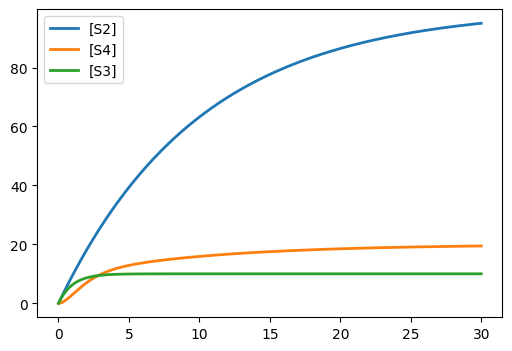

In [9]:
model3 = """
S1 -> S2; k1*S1
S2 -> S4; k2*S2
S1 -> S3; k3*S1
S3 -> S4; k4*S3
S4 -> ; k5*S4

k1 = 1
k2 = 0.1
k3 = 1
k4 = 1
k5 = 1
$S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
RR3 = te.loada(model3)
RR3.simulate(0, 30, 300)
RR3.plot()

## Step 5: Check your transfer function

In [10]:
k1 = RR3["k1"]
k2 = RR3["k2"]
k3 = RR3["k3"]
k4 = RR3["k4"]
k5 = RR3["k5"]
scale = RR3["S1"]
TRANSFER_FUNCTION = scale*((k1*k2 + k3*k4)*s + k1*k2*k4 + k2*k3*k4)/( (s+k2)*(s+k4)*(s+k5))

# Using the transfer function for compensation

\begin{eqnarray}
G(s) & = & \frac{(k_1 k_2 + k_3 k_4)s + k_1 k_2 k_4 + k_2 k_3 k_4 }{ (s + k_2) (s + k_4) (s + k_5)} \\
& = & (k_1 k_2 + k_3 k_4) \frac{s +\frac{ k_1 k_2 k_4 + k_2 k_3 k_4}{k_1 k_2 + k_3 k_4 }}{ (s + k_2) (s + k_4) (s + k_5)}\\
\end{eqnarray}

In [11]:
# Look at the poles. Which causes the S4 to converge slowly?
k2, k4, k5

(0.1, 1.0, 1.0)

Idea: Find a value of $k_1$ such that the numerator equals to $s + k_2$ so that the pole "cancels".

In [12]:
func = lambda x: (x*k2*k4 + k2*k3*k4)/(x*k2 + k3*k4)
score = 1e6
k1_best = None
for x in np.linspace(0.001, 20, 200):
    new_score = (func(x) - k2)**2
    if new_score < score:
        score = new_score
        k1_best = x
print(k1_best)

0.001


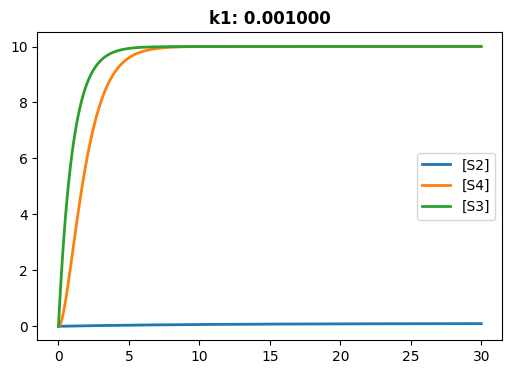

In [14]:
plotModel(model3,  k1=k1_best, times=np.linspace(0, 30, 300), title="k1: %f"%k1_best)